# IMPORT AND FUNCTIONS

In [1]:
from OSMES import *
from scipy.signal import lfilter,savgol_filter
from scipy.optimize import curve_fit

In [21]:
def build_homoligo(subject, template, coo, ac='structure', save=False):
    cmd.reinitialize()
    try:
        cmd.load(template, 'template')
    except:
        cmd.read_pdbstr(urllib.request.urlopen(template).read().decode('UTF-8'), 'template')
    cmd.split_states('template')
    cmd.delete('template')
    cmd.split_chains(f'template_0001 and polymer.protein')
    cmd.delete(f'template_0001')    
    df = match_fasta_position(pdb2fasta(subject)[0], pdb2fasta(template))
    objs = list(cmd.get_object_list('all'))
    cmd.load(subject, 'subject')
    
    n=65  ##letter A
    rmsds = []
    for mol in objs:
        chain = cmd.get_chains(mol)[0]
        if chain in set(df['sequence'].tolist()):
            cmd.create(f'sub_{mol}', f"resi {int(df[df['sequence']==chain]['query_num'].min())}-{int(df[df['sequence']==chain]['query_num'].max())} and subject")
            cmd.alter(f'(sub_{mol})', f"chain='{chr(n)}'")
            rmsd = cmd.super(f'sub_{mol}', mol, cycles=0)
            cmd.super(f'sub_{mol}', mol)
            cmd.select('site', f"byres(resi {coo.get(ac.split('_')[0])} around 10) and sub_{mol}")
            rmsd_site = cmd.super('site', mol, cycles=0)
            rmsds.append([*rmsd, *rmsd_site])
            
            n+=1
    if save:
        cmd.save(f'{ac}.pdb', 'sub_*')
    return pd.DataFrame(rmsds)

def get_res (x):
    df = pd.read_table(x)
    
    reactions = ['X1','X2', 'X3']
    CFCsBool = ['CFC_1_bool', 'CFC_2_bool', 'CFC_3_bool']
    CFCs = ['CFC_1', 'CFC_2', 'CFC_3']
    df[CFCsBool] = df[['d', *reactions]].apply(lambda x: x[reactions]==max(x[reactions]), axis=1) 
    df_mean = pd.concat(list(
            itertools.chain(*[[df.groupby('rank')[[*reactions, 'd']].mean(),
                                df.groupby('rank')['d'].count()],
                                [pd.DataFrame(df.groupby('rank')[c].apply(lambda x: len(x[x]))) for c in df[CFCsBool]]
                                ])), axis=1)
    df_mean.columns = [f'X1_mean', f'X2_mean', f'X3_mean', 'd mean', 'runs', *CFCs]
    histo = df_mean.reset_index().merge(df[['file', 'rank', 'LCC', 'affinity', 
                                           ]], on='rank')
    return histo

def calc_run_polar(run_file, dihedral):
    reactions = ['X1','X2', 'X3']
    CFCsBool = ['CFC_1_bool', 'CFC_2_bool', 'CFC_3_bool']
    pdbqt = os.path.basename(run_file[:-10])
    pdbqt = f"{os.path.dirname(os.path.dirname(run_file))}/{os.path.basename(run_file[:-10])}"

    run = os.path.basename(run_file)
    DIR = os.path.basename(os.path.dirname(run_file))
    ## PYMOL
    # try:
    cmd.reinitialize()
    cmd.load(run_file)
    # cmd.load(f"{pdbqt}.pdbqt")
    cmd.h_add(f'name {str(dihedral[2])} and not resn lys')
    n = cmd.count_atoms('not resn lys')

    angles = {}
    plane = cmd.get_coords(f"name {'+'.join(dihedral[1])} and not resn lys")
    a2,b2,c2,d2 = planeEq(*plane)
    
    # betalyase, decarboxylase
    for k,v in dihedral[0].items():
        line = cmd.get_coords(f'name {str(dihedral[2])}+{v} and not resn lys')
        a1,b1,c1 = lineEq(*line)
        angle = angle_plane_line(a1,b1,c1,a2,b2,c2)
        angles.update({k:angle})

    if len(angles)==1:
        line = cmd.get_coords(f'name {str(dihedral[2])} or id {str(n-1)} and not resn lys')
        a1,b1,c1 = lineEq(*line)
        angle = angle_plane_line(a1,b1,c1,a2,b2,c2)
        angles.update({'X1':angle})
        
    # aminotransferase
    line = cmd.get_coords(f'name {str(dihedral[2])} or id {str(n)} and not resn lys')
    a1,b1,c1 = lineEq(*line)
    angle = angle_plane_line(a1,b1,c1,a2,b2,c2)
    angles.update({'X3':angle})
    
    d = cmd.get_distance(f'name {str(dihedral[3])} and not resn lys', 'name NZ and resn lys')
    results = pd.DataFrame([[DIR, os.path.basename(run_file), d, 
                            #  h_bond, 
                              *list(angles.values())]],
                            columns = ['DIR', 'run_file', 'd', 
                                      # 'h_bond',
                                       *list(angles.keys())]
                          )    
    results[CFCsBool] = results[['d', *reactions]].apply(lambda x: x[reactions]==max(x[reactions]), axis=1) 
    return results

def plothisto(histo, figsize=(4,4), R=False, ylim=(0,150)):    

    fig,ax = plt.subplots(figsize=figsize)
    names = histo['file'].apply(lambda x: x.split('_')).tolist()[:2]
    titleName = '_'.join(sorted(set(names[0])&set(names[1]), key=names[0].index))
    
    reactions = ['CFC_1', 'CFC_2', 'CFC_3']
    reactionSet = ['decarboxylase', 'aldolase', 'aminotransferase']
    
    histo = histo[[*reactions, 'rank', 'runs', 'affinity']]
    histo['cat_runs'] = histo[reactions].apply(list, axis=1)
    histo['reaction'] = [reactionSet]*len(histo)
    histo = histo.explode(['reaction', 'cat_runs'])
    energies = histo.drop_duplicates('rank').sort_values('runs',ascending=True)

    mainRect = []
    colorsReaction = ['#99b802ff', '#4e9976ff', '#467099ff']

    off = 0.15

    for n, (i, en) in enumerate(energies.iterrows()):
        if all([en['affinity'] == energies['affinity'].min(), # Best cluster and largest cluster
                en['runs'] == energies['runs'].max()]):
            edgecolor = (.9, .8, .1)
            facecolor = (.8, .1, .1)
            # facecolor = pd.DataFrame([[.55, .8, .9], [1, .4, .25]]).mean().tolist()
            hatch = r"/"
            # hatch = r""
        elif en['affinity'] == energies['affinity'].min(): #  Best cluster
            edgecolor = 'black'
            facecolor = (.8, .1, .1)
            alpha=1
            hatch = ''
        elif en['runs'] == energies['runs'].max(): #  Largest cluster
            edgecolor = 'black'
            facecolor = (.9, .8, .1)
            alpha=1
            hatch = ''
        else:
            edgecolor = 'black'
            facecolor = (.9, .9, .9)
            alpha=1
            hatch = ''
        rect = patches.Rectangle((en['affinity']-0.16, 0), 0.32, en['runs'], 
                                linewidth=0.1,
                                edgecolor=edgecolor, 
                                facecolor=facecolor,
                                 hatch=hatch,
                                 alpha=alpha
                                )
        ax.add_patch(rect)
        off = 0.15
        for r, color, colReaction in zip(reactionSet, colorsReaction, reactions):
            if R:
                rect = patches.Rectangle((en['affinity']-off, 0), 0.1, en[colReaction], 
                                    linewidth=0.1,
                                    edgecolor='gray', 
                                    facecolor=color
                                    )
            else:
                if colReaction!='CFC_2':
                    continue
                rect = patches.Rectangle((en['affinity']-0.16, 0), 0.32, en[colReaction], 
                                        linewidth=0,
                                        edgecolor='grey', 
                                        facecolor=(0,0,.6)
                                        )
            ax.add_patch(rect)
            off-=0.1
        
    ax.set_xlim(energies['affinity'].min()-0.5,energies['affinity'].max()+0.5)
    if ylim:
        ax.set_ylim(*ylim)
    else:
        ax.set_ylim(0,energies['runs'].max()+10)
    ax.set_xlabel('Binding Energy (kcal/mol)')
    ax.set_ylabel('# Conformations')
    fig.tight_layout()
    # ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    # ax.legend(['all', f'C-H{chr(945)}', f'C-C{chr(946)}', f'C-COOH'])
    plt.close()
    return fig, ax

def spectra(df):
    #plotting
    fig, ax1 = plt.subplots(1,1,figsize=(4,3))
    # ax2 = fig.add_axes([0.55, 0.5, 0.3, 0.3])
    ax1.plot(df[0],df[1], color = 'black')
    ax1.set_xlim([df.min()[0],df.max()[0]])
    # ax1.set_ylim([df.min()[1], df.max()[1]+0.1])
    ax1.set_ylabel('Absorbance')
    ax1.set_xlabel('Wavelength (nm)')
    # ax2.plot(df[0],df[1], linewidth=0.5,color='black')
    # ax2.set_xlim([380, 450])
    # ax2.set_ylim([0.04, 0.1])
    return fig

def plot_kin(df):
    df_cols = list(df.columns)
    for c in df_cols[::2]:
        df[c] = df[c].round()
    for c in (df_cols[1::2]):
        df[c] -= df[(df[c-1].values  == 500)].values[0][c]
    n = 10  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1

    x = df[df_cols[::2]]
    x.columns = pd.RangeIndex(x.columns.size)
    x=x.add_prefix('X')
    y = df[df_cols[1::2]]
    y.columns = pd.RangeIndex(y.columns.size)
    y=y.add_prefix('Y')
    xy = pd.concat([x, y], axis=1)
    yy = lfilter(b,a,y)
    #smoothing
#     xnew = np.linspace(x.min(), x.max(), 300)
#     spl = make_interp_spline(x, y, k=3)  # type: BSpline
#     power_smooth = spl(x,y)

#     plt.plot(xnew, power_smooth)
#     plt.show()
    
    #plotting
    fig, ax1 = plt.subplots()
    # ax2 = fig.add_axes([0.65, 0.6, 0.2, 0.2])
    ax1.plot(x, y, linewidth=0.5)
    ax1.set_xlim([270, 450])
    ax1.set_ylim([0, 3])
    ax1.set_ylabel('Absorbance')
    ax1.set_xlabel('Wavelength (nm)')
    plt.arrow(365, 2, 0, -0.3, length_includes_head=True,
              head_width=1.5, head_length=0.05, color ='black')
    plt.arrow(340, 0.5, 0, 0.3, length_includes_head=True,
              head_width=1.5, head_length=0.05, color ='black')
    #ax2.plot(x, y, linewidth=0.5)
    # ax2.set_xlim([270, 300])
    # ax2.set_ylim([0.8, 1.2])

    return fig, ax1

def highlight(s):
    if s.Metrics == 'cotr_score':
        return ['background-color: lightgrey'] * len(s)
    else:
        return ['background-color: white'] * len(s)
    
def padding(x):
    if x.dtype=='object':
        return ['padding-right: 1.9em' for val in x]
    else:
        return ['padding-left: 1.9em' for val in x]

def MM(x, vmax, km):
    return (vmax*x)/(km+x)

def legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM'):
    result = [r'$k_{cat}$ =', str(round(popt[0], 3)), 
               u"\u00B1", str(round(perr[0], 3)), 's\u207b\N{SUPERSCRIPT one}', '\n',
               r'$K_{M}$ =', str(round(popt[1], 3)),
               u"\u00B1", str(round(perr[1], 3)), unit, '\n',
               r'$k_{cat}$/$K_{M}$ =', str(round(cat_eff, 3)), 
               u"\u00B1", str(round(cat_eff_error, 3)), 'M\u207b\N{SUPERSCRIPT one}s\u207b\N{SUPERSCRIPT one}', '\n',
               'R\N{SUPERSCRIPT two} =', str(round(R2, 3))
              ]
    return ' '.join(result)

# rcParams

In [3]:
mpl.rcParams['axes.linewidth'] = 0.1
mpl.rcParams['lines.linewidth'] = 0.1
mpl.rcParams['font.size'] = 10
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 4
mpl.rcParams['legend.title_fontsize'] = 4
mpl.rcParams['xtick.major.width'] = 0.1
mpl.rcParams['ytick.major.width'] = 0.1
mpl.rcParams["legend.markerscale"] = 0.25
mpl.rcParams["hatch.linewidth"] = 8

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

# Dictionaries

In [4]:
enzyme =   {
            'GLU':{'D':['P48320','P48318',
                        'Q05329', 'Q99259',
                       ],
                  },
            'TYR':{'D':['O88533',
                        'P20711'
                       ],
                   'A':['Q8QZR1',
                        'P17735'
                       ],
                  },
            'HIS':{'D':['P23738','P19113'], #HDC
                  },
            'CSU':{'D':['Q9DBE0', 'Q9Y600', #CSAD
                        'Q80WP8', 'Q6ZQY3', #GADL1
                       ],
                  },
            'ASP':{'D':['Q9DBE0', 'Q9Y600', #CSAD
                        'Q80WP8', 'Q6ZQY3', #GADL1
                       ],
                  },
            'KYN':{'A':['Q8BTY1', 'Q71RI9', 'Q9WVM8', 
                         'Q16773', 'Q6YP21', 'Q8N5Z0', 
                        ],
                   'O':['Q9CXF0', 'Q16719'] #KYNU
                   },
            'CYT':{'O':['Q8VCN5', 'P32929'], #CTH
                  },
            'ILE':{'A':['P24288', 'O35855', 
                        'P54687', 'O15382',
                       ]},
            'SPL':{'B':['O95470','Q8R0X7'] #SGPL1
                  },
            'ALA':{'A':['P24298', 'Q8QZR5', # GPT
                        'Q8TD30', 'Q8BGT5' # GPT2
                       ],
                  },
            'PSE':{'A':['Q99K85', 'Q9Y617'] #PSAT
                  }, 
            'CYS':{'O':['Q9Y697', 'Q9Z1J3'] # NFS1
                  },
            'SER':{'B':['P50431', 'Q9CZN7',
                        'P34896', 'P34897',
                       ],
                  },
            'THR':{'O':['P20132', 'Q8VBT2', #SDS
                        'Q8R238', 'Q96GA7', #SDSL
                       ]},
            'PHL':{'O':['Q8R1K4', 'Q8IUZ5', #Phykpl
                       ]},
            'EAP':{'O':['Q8BWU8', 'Q8TBG4', #ETNPPL
                       ]},
            'DMA':{'A':['Q9BYV1', 'Q3UEG6', #AGXT2
                   ]},
            'HTL':{'B':['Q6XPS7', 'P50431', 'Q9CZN7',
                        'P34896', 'P34897',
                       ],
                  },

            'ORN':{'D':['P00860', 'P11926']
                  }
           }
CFCDict = {
    'D':'CFC_1',
    'B':'CFC_2',
    'A':'CFC_3',
    'O':'CFC_3',
}

palette = {
           'LCC':(.9,.8,.1),
           'LCE':(1,1,.3),
           'LCaaE':(1,1,.7),
           'CC-CFC':(0,0,.6),
           'BCC':(.8,.1,.1),
           'BCE':(1,.3,.3),
           'BCaaE':(1,.5,.5),
           'Random':'black',
           'percentage':'cyan',
           'diff':'lightblue',
           }

lig_palette = {'HIS':'magenta',
               'CYT':'limegreen',
               'KYN':'pink',
               'THR':'gray',
               'ASP':'violet',
               'GLU':'cyan',
               'EAP': 'salmon',
               'ORN':'slateblue',
               'HTL':'green',
               'TYR':'yellow',
               'PSE':'brown',
               'CSU':'gold',
               'ILE':'black',
               'DMA':'darkgrey',
               'SER':'white',
               'SPL':'red',
               'PHL':'blue',
               'CYS':'cadetblue',
               'ALA':'blue'
              }

reaction_palette = {'B':'#4e9976ff',
                    'A':'#99b802ff',
                    'D':'#467099ff',
                    'O':'#18b5adff'
                   }



# Fig. 2 + Supplementary Fig. 3

In [5]:
TPS = []
for file in glob.glob('Fig_2/rank_*tsv'):
    ranksDf = pd.read_table(file)
    lig = os.path.splitext(file)[0].split('_')[-1]
    TP = enzyme.get(lig)
    for k,v in TP.items():
        ranksDf['score'] = ranksDf['Entry'].apply(lambda x: 0 if x in TP.get(k) else 1)
        ranksDf['reaction'] = k
        TPS.append(ranksDf[ranksDf['ranking']==CFCDict.get(k)])

    ranksDf['score'] = ranksDf['Entry'].apply(lambda x: 0 if x in list(itertools.chain(*TP.values())) else 1)
    TPS.append(ranksDf[~ranksDf['ranking'].str.contains("CFC")])

TPS = pd.concat(TPS)
TPS['ranking'] = TPS['ranking'].apply(lambda x: x.split(' ')[-1])
# set(TPS['lig'])

In [6]:
rankName = {
    'affinity_LC':'LCE',
    'affinity_BC':'BCE',
    'ade_mean_LC':'LCaaE',
    'ade_mean_BC':'BCaaE',
    'CFC_1':'CC-CFC',
    'CFC_2':'CC-CFC',
    'CFC_3':'CC-CFC',
    'runs_BC':'BCC',
    'runs_LC':'LCC',
    # 'runs_perc':'percentage',
    # 'runs_diff':'diff',
           }
TPS['ranking'] = TPS['ranking'].apply(lambda x:rankName.get(x))
TPS = TPS.set_index('ranking')
TPS = TPS.loc[['BCC', 'BCE', 'BCaaE', 'LCC', 'LCE', 'LCaaE', 'CC-CFC']].reset_index()
# TPS = TPS.dropna()
set(TPS['ranking'])

{'BCC', 'BCE', 'BCaaE', 'CC-CFC', 'LCC', 'LCE', 'LCaaE'}

## Fig. 2d

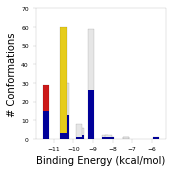

In [7]:
histo = pd.read_table('../AF_db_autosize/GLU_PLP_Mus_musculus_14.5_30-12-2022_1/Q91WT9_SWISSMODEL_B.tsv')

fig, ax = plothisto(histo,(2.5,2.5), ylim=False)
fig.savefig('Fig_2d.pdf')
fig

## BOXENPLOT

### Fig. 2e

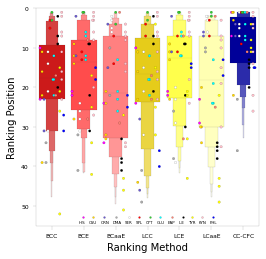

In [8]:
fig, ax = plt.subplots(figsize =(4, 4)) 



sns.boxenplot(data=TPS[TPS['score']==0], x = 'ranking', y='rank', 
              ax = ax,
              linewidth = 0.1,
              saturation=1,
              palette = palette,
              k_depth='full',
              showfliers=False,
              # line_kws={'medianprops':'white'}
             )
sns.swarmplot(data=TPS[TPS['score']==0], x = 'ranking', y='rank', 
              dodge=True,
              palette=lig_palette,
              size=2.5,
              linewidth=0.1,
              hue='lig',
              ax=ax
             )

plt.xticks(rotation=0)
plt.xlabel('Ranking Method')
plt.ylabel('Ranking Position')
ax.set(ylim=(55,0))

handle, label = ax.get_legend_handles_labels()
for h in handle:
    h.set_linewidth(0.1)
    h.set_ec('black')
    
    
legend = ax.legend(handle, label,
                   title='', 
                   loc = (0.185, 0.025),
                   # loc = 'lower center',
                   ncol=len(set(TPS['lig'])),
                   columnspacing=-2,
                   frameon=False,
                   edgecolor='black'
                  )
for line in legend.get_lines():
    line.set_linewidth(10)
for txt in legend.get_texts():
    txt.set_ha("center") # horizontal alignment of text item
    txt.set_x(-11) # x-position
    txt.set_y(-5) # y-position
    # txt.set_text('')
    

# plt.legend(handle,label)

[ax.spines[i].set_linewidth(0.1) for i in list(ax.spines)]

# plt.text(0.5, 53, '    '.join(TPS['lig'].drop_duplicates().tolist()), fontsize = 4)
fig.savefig(f'Fig_2e.pdf')

### Supplementary Fig.3a

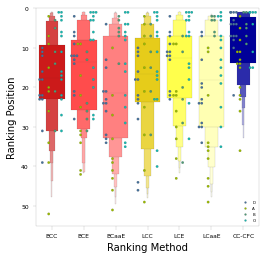

In [9]:
fig, ax = plt.subplots(figsize =(4, 4)) 

sns.boxenplot(data=TPS[TPS['score']==0], x = 'ranking', y='rank', 
              ax = ax,
              linewidth = .1,
              palette = palette,
              saturation=1,
              k_depth='full',
              showfliers=False
             )
sns.swarmplot(data=TPS[TPS['score']==0], x = 'ranking', y='rank', 
              dodge=True,
              palette = reaction_palette,
              size=2.5,
              linewidth=0.1,
              hue='reaction',
              ax=ax
             )

handle, label = ax.get_legend_handles_labels()
for h in handle:
    h.set_linewidth(0.1)
    h.set_ec('black')
    
legend = ax.legend(handle, label,
                   title='', 
                   # loc = 'lower center',
                   # ncol=len(set(TPS['lig'])),
                   # columnspacing=-2,
                   frameon=False,
                   edgecolor='black'
                  )
plt.xlabel('Ranking Method')
plt.ylabel('Ranking Position')
ax.set(ylim=(55,0))
fig.savefig(f'Supplementary_Fig_3_a.pdf')

## ROC AUC

### Fig. 2f

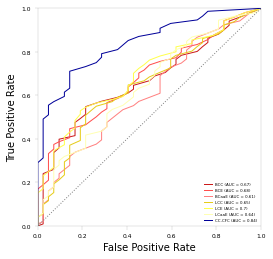

In [10]:
fig, ax = plt.subplots(figsize =(4,4)) 
from sklearn import metrics

for ran in TPS['ranking'].dropna().drop_duplicates():

    y = TPS[TPS['ranking']==ran]['score']
    scores = TPS[TPS['ranking']==ran]['rank']
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)

    lw = 1
    plt.plot(
        fpr,
        tpr,
        color=palette.get(ran),
        lw=lw,
        label = f"{ran} (AUC = {round(metrics.auc(fpr,tpr),2)})",
    )
    lim = [0, 1]
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right", 
               # title='Ranking Methods', 
               frameon=False)
plt.plot(lim, lim, color="grey", lw=lw, linestyle=":")

plt.show()
fig.savefig('Fig_2f.pdf')


### Supplementary Fig. 3b

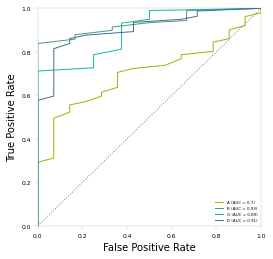

In [11]:
fig, ax = plt.subplots(figsize =(4, 4)) 
from sklearn import metrics
for ran in set(TPS['reaction']):
    tab = TPS[TPS['ranking']=='CC-CFC']
    y = tab[tab['reaction']==ran]['score']
    scores = tab[tab['reaction']==ran]['rank']
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)

    lw = 1
    plt.plot(
        fpr,
        tpr,
        color=reaction_palette.get(ran),
        lw=lw,
        label = f"{ran} (AUC = {round(metrics.auc(fpr,tpr),2)})",
    )
    # plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    lim = [-0.05, 1.05]
    lim = [0,1]
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", frameon=False)
plt.plot(lim, lim, color="grey", lw=lw, linestyle=":")
plt.show()
fig.savefig(f'Supplementary_Fig_3_b.pdf')


In [12]:
def plothisto(histo):    
    mpl.rcParams['axes.linewidth'] = 0.1
    mpl.rcParams['lines.linewidth'] = 0.1
    mpl.rcParams['font.size'] = 10
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['legend.fontsize'] = 4
    mpl.rcParams['legend.title_fontsize'] = 4
    mpl.rcParams['xtick.major.width'] = 0.1
    mpl.rcParams['ytick.major.width'] = 0.1
    mpl.rcParams["legend.markerscale"] = 0.25
    plt.rcParams["hatch.linewidth"] = 8
    fig,ax = plt.subplots(figsize=(4,4))
    names = histo['file'].apply(lambda x: x.split('_')).tolist()[:2]
    titleName = '_'.join(sorted(set(names[0])&set(names[1]), key=names[0].index))

    histo = histo[['(A) runs', '(B) runs', '(D) runs', 'rank', 'runs', 'affinity']]
    histo['cat_runs'] = histo[['(A) runs', '(B) runs', '(D) runs']].apply(list, axis=1)
    histo['reaction'] = [['aminotransferase', 'betalyase', 'decarboxylase']]*len(histo)
    histo = histo.explode(['reaction', 'cat_runs'])
    energies = histo.drop_duplicates('rank').sort_values('runs',ascending=True)

    mainRect = []
    # colorsReaction = ['white', 'pink', 'red']
    colorsReaction = ['#99b802ff', '#4e9976ff', '#467099ff']
    off = 0.15
    reactionSet = set(histo['reaction'])

    for n, (i, en) in enumerate(energies.iterrows()):
        if all([en['affinity'] == energies['affinity'].min(), # Best cluster and largest cluster
                en['runs'] == energies['runs'].max()]):
            edgecolor = (.9, .8, .1)
            facecolor = (.8, .1, .1)
            alpha=.8
            # facecolor = pd.DataFrame([[.55, .8, .9], [1, .4, .25]]).mean().tolist()
            hatch = r"/"
            # hatch = r""
        elif en['affinity'] == energies['affinity'].min(): #  Best cluster
            edgecolor = 'black'
            facecolor = (.8, .1, .1)
            alpha=.8
            hatch = ''
        elif en['runs'] == energies['runs'].max(): #  Largest cluster
            edgecolor = 'black'
            facecolor = (.9, .8, .1)
            alpha=.8
            hatch = ''
        else:
            edgecolor = 'black'
            facecolor = (.9, .9, .9)
            alpha=1
            hatch = ''
        rect = patches.Rectangle((en['affinity']-0.16, 0), 0.32, en['runs'], 
                                linewidth=0.1,
                                edgecolor=edgecolor, 
                                facecolor=facecolor,
                                 hatch=hatch,
                                 alpha=alpha
                                )
        ax.add_patch(rect)
        off = 0.15
        for r, color in zip(sorted(list(reactionSet)), colorsReaction):
            colReaction = f'({r[0].upper()}) runs'
            rect = patches.Rectangle((en['affinity']-off, 0), 0.1, en[colReaction], 
                                    linewidth=0.1,
                                    edgecolor='gray', 
                                    facecolor=color
                                    )
            ax.add_patch(rect)
            off-=0.1
        
    ax.set_xlim(energies['affinity'].min()-0.5,energies['affinity'].max()+0.5)
    # ax.set_ylim(0,energies['runs'].max()+10)
    ax.set_ylim(0,150)
    ax.set_xlabel('Binding Energy (kcal/mol)')
    ax.set_ylabel('# Conformations')
    
    
    # handle, label = ax.get_legend_handles_labels()
    # print(handle)
    # for n,h in enumerate(handle):
    #     print(h)
    #     # if n==4:
    # # h.set_linewidth(0.1)
    #     h.set_ec('red')
        
    ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    ax.legend(['all', f'C-H{chr(945)}', f'C-C{chr(946)}', f'C-COOH', 'BC', 'LC'])

    
    plt.close()
    return fig, ax

In [13]:
for a in {'147', '143', '324', '76', '106', '253', '277', '225', '96', '142', '410', '144', '166', '320', '425', '226', '227', '325', '326', '409', '105', '172', '170', '251', '254', '280', '279', '98', '408', '174', '411', '171', '173', '169'}:
    print('U', 'O', a)
    

U O 409
U O 325
U O 225
U O 170
U O 279
U O 280
U O 96
U O 326
U O 324
U O 425
U O 171
U O 143
U O 98
U O 254
U O 320
U O 408
U O 411
U O 147
U O 277
U O 166
U O 172
U O 105
U O 251
U O 226
U O 173
U O 106
U O 144
U O 169
U O 142
U O 174
U O 76
U O 410
U O 227
U O 253


# Fig. 4a

## Functions for table

In [16]:
columns_name = {'rank':' ',
                'Gene name':'Gene', 
                'CFC_2':'CC-CFC',
                'X2_mean':'|sin(χ\N{SUBSCRIPT two})|',
                'd mean':'d',
                'affinity':'E (kcal/mol)'
               }

def style_table(df,column_ranking,rows=False):
    '''return styled table svg with ranking of a given column'''
    df = df[df['ranking']==column_ranking]
    if rows:
        df = df.head(rows)
    df['Gene name'] = df['Gene names'].apply(lambda x: x.split(' ')[0])
    tab = (df[['rank','Entry','Gene name', 'EC number',column_ranking, 
               'X2_mean',
               'LCC', 
               'd mean', 
               'affinity',
              ]]
          )
    tab['LCC']=tab['LCC'].astype(int)
#     tab['Catalytic LC']=tab['Catalytic LC'].astype(int)
    tab['d mean']=tab['d mean'].astype(float)
#     tab['1LC/2LC %']=tab['1LC/2LC %'].astype(float)
    styles = [
                dict(props=[
#                             ('font-size','20pt'),
                            ('font-family','Arial'),
                            ('text-align','center'),
                            ('width', '1500px'),
                            ('height','100px'),
                            ('display.precision', 2),
            ]),
                dict(selector='tr:nth-child(even)',
                     props=[('background-color','whitesmoke')])
             ]
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_columns', 0)
    tab = tab.rename(columns=columns_name)
    styled_table = (tab
                    .style
                    # .apply(lambda x: ['background: lightgreen' 
                    #                                     if (x.name in df[df['Entry'].isin(enzyme.get(df['lig'].iloc[0]))]
                    #                                         .index.to_list())
                    #                                     else '' for i in x], axis=1)
                    # .set_table_styles(styles)
                    .set_precision(2)
                    # .bar(vmin=0,vmax=100,subset=['LC_runs'], color='khaki')
                    # .bar(vmin=0,vmax=100,subset=[column_ranking], color='khaki')
                    # .background_gradient(subset=['d\u0305', ],
                    #                      low=0.5, high=0, 
                    #                      cmap='Purples_r')
                    .background_gradient(subset=['|sin(χ\N{SUBSCRIPT two})|' ],
                                         # low=0.5, high=0, 
                                         cmap=mpl.colors.LinearSegmentedColormap.from_list("", ['white','#4e9976ff'])
                                        )
                    .background_gradient(subset='E (kcal/mol)', 
                                         low=0.5, high=0, 
                                         cmap='Reds_r')
                    .background_gradient(subset=['CC-CFC'], 
                                         low=0, high=0, 
                                         cmap=mpl.colors.LinearSegmentedColormap.from_list("", ['white','#000099ff'])
                                        )
                    .background_gradient(subset=['LCC'], 
                                         low=0, high=0, 
                                         cmap=mpl.colors.LinearSegmentedColormap.from_list("", ['white','#e6cc19ff'])
                                        )
                    .format(na_rep='N/A', precision=2)
                  )

    # imgkit.from_string(html, df['Ligand'].iloc[0]+'_'+column_ranking.replace(" ", "_").strip(' (kcal/mol)')+organism+'.svg')
    return styled_table

def align(x):
    if x.dtype=='object':
        return ['text-align: left' for val in x]
    else:
        return ['text-align: right' for val in x]
    
def highlight(s):
    if s.Metrics == 'cotr_score':
        return ['background-color: lightgrey'] * len(s)
    else:
        return ['background-color: white'] * len(s)
    
def padding(x):
    if x.dtype=='object':
        return ['padding-right: 1em' for val in x]
    else:
        return ['padding-left: 1em' for val in x]

font_size=2.8


general = [
          dict(selector=" ",
               props=[('font-family',
                       # "Helvetica", 
                       "Arial", 
                       # 'sans-serif'
                      ),
                      ('font-weight', 'normal'),
                      ('width','600'),
                      # ('width','auto'),
                      ('border-collapse', 'collapse'),
('font-size', f'{str(font_size)}mm'),
                      
                     ]),
            dict(selector="td", 
                 props=[
                     ("padding", ".2em"),
                     ('border-right', '1px solid grey'),
                     ('border-left', '1px solid grey'),
                     ('border-bottom', '1px solid grey'),
                     ('border-top', '1px solid grey'),
                     # ("text-align", "right")
                       ]),
            dict(selector="th", 
                 props=[
                     ("font-size", "100%"),
                     ("padding", ".4em"),
                     ('border-bottom', '2px solid black'),
                     ('border-top', '2px solid black'),
                     ('border-right', '1px solid grey'),
                     ('border-left', '1px solid grey'),
                     ("text-align", "center")]),
          ]


## Mus musculus

In [17]:
df_mus = pd.read_table(f'Fig_4/rank_Mus_musculus_HTL.tsv')

s = style_table(df_mus, 'CFC_2', False)
s = s.apply(lambda x: ['background-color: #ffc14c' 
                       if (x.Gene in ['Shmt1', 'Shmt2', 'SHMT1', 'SHMT2', 
                                      'Sgpl1', 'SGPL1', 'Tha1', 
                                      'Kyat1', 'KYAT1', 'Kyat3', 'KYAT3'])
                       else '' for i in x], 
            axis=1, 
            subset=['Gene']
           )
html = s.set_table_styles(general).hide(axis='index').apply(align)#.apply(padding)
html

print('''<meta charset="utf-8">\n''', html.to_html(), file=open(f'Fig_4_Mus.html', 'w'))

import pdfkit as pdf
pdf.from_file(f'Fig_4_Mus.html',f'Fig_4_Mus.pdf', options={'page-size': 'A4'})
s

,Entry,Gene,EC number,CC-CFC,|sin(χ₂)|,LCC,d,E (kcal/mol)
1,P50431,Shmt1,2.1.2.1,113,0.81,152,3.95,-10.00
2,Q8BG54,Sptlc3,2.3.1.50,82,0.76,136,4.61,-10.10
3,Q9CZN7,Shmt2,2.1.2.1,77,0.80,103,3.92,-10.30
4,P61922,Abat,2.6.1.19; 2.6.1.22,71,0.79,104,3.97,-8.90
5,Q8VC19,Alas1,2.3.1.37,64,0.67,155,4.29,-11.40
6,P97363,Sptlc2,2.3.1.50,61,0.70,134,4.62,-9.50
7,Q8VCN5,Cth,4.4.1.1,53,0.68,140,3.44,-12.10
8,Q9QZX7,Srr,5.1.1.18; 4.3.1.18; 4.3.1.17,52,0.71,111,3.90,-11.00
9,Q6XPS7,Tha1,N/A,51,0.72,111,4.83,-9.10
9,P08680,Alas2,2.3.1.37,51,0.67,155,3.65,-10.60


## Homo sapiens

In [18]:
df_homo = pd.read_table(f'Fig_4/rank_Homo_sapiens_HTL.tsv')
s = style_table(df_homo, 'CFC_2', False)

s = s.apply(lambda x: ['background-color: #ffc14c' 
                       if (x.Gene in ['Shmt1', 'Shmt2', 'SHMT1', 'SHMT2', 
                                      'Sgpl1', 'SGPL1', 'Tha1', 
                                      'Kyat1', 'KYAT1', 'Kyat3', 'KYAT3'])
                       else '' for i in x], 
            axis=1, 
            subset=['Gene']
           )
html = s.set_table_styles(general).hide(axis='index').apply(align).apply(padding)
html

print('''<meta charset="utf-8">\n''', html.to_html(), file=open(f'Fig_4_Homo.html', 'w'))

import pdfkit as pdf
pdf.from_file(f'Fig_4_Homo.html',f'Fig_4_Homo.pdf', options={'page-size': 'A4'})
s

,Entry,Gene,EC number,CC-CFC,|sin(χ₂)|,LCC,d,E (kcal/mol)
1,P34896,SHMT1,2.1.2.1,116,0.81,153,3.74,-10.40
2,P34897,SHMT2,2.1.2.1,102,0.80,142,3.63,-11.10
3,P80404,ABAT,2.6.1.19; 2.6.1.22,75,0.71,142,3.95,-9.40
4,P20711,DDC,4.1.1.28,67,0.69,110,3.81,-8.30
5,P32929,CTH,4.4.1.1,63,0.69,182,3.82,-11.30
5,Q96I15,SCLY,4.4.1.16,63,0.70,144,3.66,-9.10
7,P13196,ALAS1,2.3.1.37,61,0.71,143,3.97,-10.70
8,Q6YP21,KYAT3,2.6.1.7; 4.4.1.13; 2.6.1.63,60,0.66,160,3.68,-12.10
9,Q9NUV7,SPTLC3,2.3.1.50,57,0.74,129,4.03,-10.30
10,O15270,SPTLC2,2.3.1.50,53,0.72,139,4.39,-10.20


# Fig. 5

In [19]:
font_size=2


general = [
          dict(selector=" ",
               props=[('font-family','"Helvetica", "Arial", sans-serif'),
                      ('font-weight', 'normal'),
                      ('width','auto'),
                      ('border-collapse', 'collapse'),
('font-size', f'{str(font_size)}mm'),
                      
                     ]),
            dict(selector="td", 
                 props=[
                     # ("padding", ".2em"),
                     ('border-right', '1px solid grey'),
                     ('border-left', '1px solid grey'),
                     ('border-bottom', '1px solid grey'),
                     ('border-top', '1px solid grey'),
                     ("text-align", "center")
                       ]),
            dict(selector="th", 
                 props=[
                     ("font-size", "100%"),
                     ("padding", ".4em"),
                     ('border-bottom', '2px solid black'),
                     ('border-top', '2px solid black'),
                     ('border-right', '1px solid grey'),
                     ('border-left', '1px solid grey'),
                     ("text-align", "center")]),
          ]

## Fig 5b

$k_{cat}$ = 0.123 ± 0.005 s⁻¹ <br> $K_{M}$ = 3.793 ± 0.35 mM <br> $k_{cat}$/$K_{M}$ = 32.396 ± 4.329 M⁻¹s⁻¹ <br> R² = 0.993

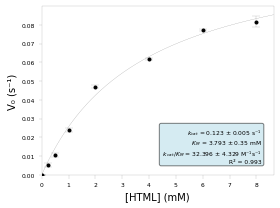

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

p = pd.read_table('Fig_5/MM_SHMT1_html.tsv')
x, y = p['mM'], p['mean']/60
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['SEM']/60, 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[HTML] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')

ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=6,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.tight_layout()
plt.plot(toplot, MM(toplot, *popt), 'black')

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Fig_5_b.pdf')


## Fig. 5c

In [23]:
cat = pd.read_table('Fig_5/cat_efficiency.csv', sep =';')
html = (cat.round(3)
                .style
                .set_table_styles(general)
                .hide(axis='index')
                .applymap(lambda x: 'background-color: transparent' if pd.isnull(x) else '')
                .applymap(lambda x: 'color: black' if pd.isnull(x) else '')
                .format(na_rep='N/A', precision=3)
       )

print('''<meta charset="utf-8">\n''',html.to_html(), file=open('Fig_5_c.html', 'w'))

import pdfkit as pdf
pdf.from_file('Fig_5_c.html','Fig_5_c.pdf', options={'page-size': 'A4'})
cat

,Organism,Enzyme,kcat,KM,kcat/KM
0,Homo sapiens,SHMT1,0.123 ± 0.005,3.793 ± 0.35,32.396 ± 4.329
1,Homo sapiens,SHMT2,0.005 ± 0.0,0.803 ± 0.067,6.311 ± 0.674
2,Homo sapiens,KYAT1,NaN,NaN,NaN
3,Homo sapiens,SGPL1,NaN,NaN,NaN
4,Mus musculus,Tha1,2.311 ± 0.029,0.169 ± 0.009,"13,695.069 ± 892.495"
5,Mus musculus,Kyat3,NaN,NaN,NaN


## Fig. 5e

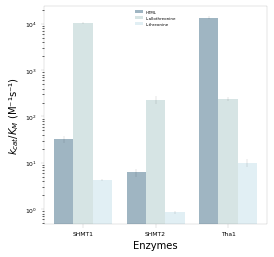

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
data = pd.read_table(StringIO('''Enzymes	substrate	mean	sterror
SHMT1	HTML	3.22E+01	5
SHMT1	L-allothreonine	1.05E+04	562.441
SHMT1	L-threonine	4.208E+00	0.242
SHMT2	HTML	6.23E+00	1.26
SHMT2	L-allothreonine	2.32E+02	42
SHMT2	L-threonine	0.846E+00	0.06
Tha1	HTML	1.37E+04	892
Tha1	L-allothreonine	2.38E+02	19
Tha1	L-threonine	1.00E+01	2
'''))

ax = sns.barplot(data=data, 
                 x='Enzymes', 
                hue='substrate',
                y='mean',
                 palette=['#99b6c8ff', '#d4e6e6ff', '#def1f7ff'], 
                )
x_coords = ([p.get_x() + 0.5 * p.get_width() for p in ax.patches])
y_coords = [p.get_height() for p in ax.patches]
coords = [tuple(data[data['mean']==y]['mean'].index) for y in y_coords]
coords = list(itertools.chain(*sorted(set(coords), key=coords.index)))
coords = pd.DataFrame(zip(coords, x_coords, y_coords)).sort_values(0)

ax.errorbar(x=coords[1], y=coords[2], yerr=data["sterror"], 
            fmt="none", c="k"
           )
ax.legend(frameon=False,
          loc='upper center'
         )

ax.set_yscale("log")
ax.set_ylabel(r'$k_{cat}$/$K_{M}$'+' (M\u207b\N{SUPERSCRIPT one}s\u207b\N{SUPERSCRIPT one})')
fig.savefig('Fig_5_e.pdf')

# Fig. 6

## Fig. 6e,g

Fig_6/HTL_PLP_Q6XPS7_Tha1_F222_refine_63_Parma2_Tetramero_B/
Fig_6/HTL_PLP_Q6XPS7_SWISSMODEL_A/


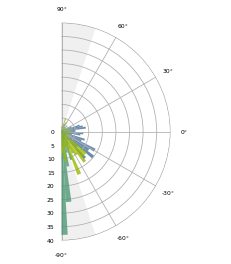

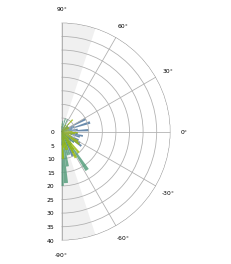

In [26]:
reactions = ['X1', 'X2', 'X3']
for DIR in glob.glob('Fig_6/HTL_PLP*/'):
    print(DIR)
    fig, ax = plt.subplots(1,1, 
                             figsize=(4,4), 
                             subplot_kw={'projection': 'polar'}) 
    sw_list = []
    for x in glob.glob(f'{DIR}/*.pdbqt'):
        sw_list.append(calc_run_polar(x,eval(open('Fig_6/HTL_PLP.txt').read())))
    swar = pd.concat(sw_list)    

    dfs, lims = [], []
    for col, color, size in zip(reactions,
                   ['#467099ff', '#4e9976ff', '#99b802ff'],
                   [1,2,3],
                             # axes
                                   ):

        ax.set_xticklabels(['0', '45', '90', '45', '0', '-45', '-90', '-45', ])
        ax.set_xticklabels(reversed(['90°', '60°', '30°', '0°', '-30°', '-60°', '-90°',]))
        ax.set_ylim([0,40])

        # df = swar[[col]]*np.pi*2
        df = swar[[col]].apply(lambda x: np.arcsin(x))
        df = df.rename(columns={col:'angle'})
        df['kind'] = col#[-2]
        df['y'] = 'prova'
        dfs.append(df)
        # ax.set_rticks([])
        lims.append(ax.get_ylim()[1])


        ax.hist(df['angle']*np.pi/2,
                 bins=50,
                 color=color,
                alpha=0.8,
                zorder=size,
                align='right',
                )
        # plt.yticks(fontsize='x-large')
        # plt.xticks(fontsize='x-large')
    ax.bar([np.pi/2, np.pi*1.5], [max(lims)]*2, [(np.pi/2-np.arcsin(0.95))*2]*2, alpha=0.33, bottom=0, color='lightgrey', zorder=0,
           align='center'
          )
    ax.set_thetamin(-90)
    ax.set_thetamax(90)
    # ax.ThetaDir = 'clockwise'
    panel = 'e' if 'SWISS' in DIR else 'g' 
    fig.savefig(f'Fig_6_{panel}.pdf')
    # fig.savefig('HTL_PLP_Q6XPS7_tha_template_padova_only_tetramero_B_polar_plot.pdf')
    # fig.savefig('HTL_PLP_Q6XPS7_tha_template_padova_tetramero_B_polar_plot.pdf')
    # fig.savefig('Tha1_F222_refine_63_Parma2_Tetramero_B_polar_plot.pdf')
    fig

## Fig. 6d,f

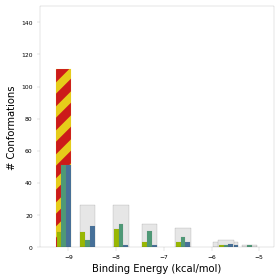

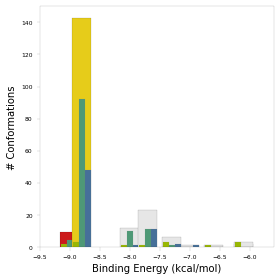

In [27]:
for df in glob.glob('Fig_6/*.tsv'):
    panel = 'd' if 'SWISS' in df else 'f'
    histo = pd.read_table(df)
    fig, ax = plothisto(histo, R=True)
    fig.savefig(f'Fig_6_{panel}.pdf')
    display(fig)

# Supplementary Fig. 1

In [31]:
import os
from Bio.PDB.PDBParser import PDBParser
import warnings
warnings.filterwarnings('ignore')
from Bio.PDB import PDBParser as PDB, PDBIO
import glob
from pymol import stored

coord_h = pd.read_table('Supplementary_Table_1/Homo_sapiens_coord.tsv').dropna()
coord_m = pd.read_table('Supplementary_Table_1/Mus_musculus_coord.tsv').dropna()

parser = PDBParser()
ppd = [np.array([atom.get_bfactor() 
        for model in parser.get_structure('b',file) 
        for chain in model 
        for res in chain 
        for atom in res])
       for file in set(map(lambda x: f"../../PLP_enzymes/Mus_musculus/AF_db/{x}",set(coord_m['pdb']))) |
       set(map(lambda x: f"../../PLP_enzymes/Homo_sapiens/AF_db/{x}",set(coord_h['pdb'])))
       ]
len(ppd)

105

In [32]:
perc = list(map(lambda x: len(x[x>=90])/len(x), ppd))
ppd_list = list(itertools.chain(*ppd))

In [33]:
gg = []
for file in set(coord_h['pdb']):
    cmd.reinitialize()
    cmd.load(f"../../PLP_enzymes/Homo_sapiens/AF_db/{file}", 'prova')
    for i,r in coord_h[coord_h['pdb']==file].iterrows():
        stored.list=[]
        cmd.select('l', f"resi {int(r['res'])} and prova and chain {r['chain']} around 10")
        cmd.iterate('l',f"stored.list.append((b,resn))")
        gg.append({'file':file,
                   'chain':r['chain'],
                   'res':stored.list}
                )

for file in set(coord_m['pdb']):
    cmd.reinitialize()
    cmd.load(f"../../PLP_enzymes/Mus_musculus/AF_db/{file}", 'prova')
    for i,r in coord_m[coord_m['pdb']==file].iterrows():
        stored.list=[]
        cmd.select('l', f"resi {int(r['res'])} and prova and chain {r['chain']} around 10")
        cmd.iterate('l',f"stored.list.append((b,resn))")
        gg.append({'file':file,
                   'chain':r['chain'],
                   'res':stored.list}
                )


In [34]:
b_df = pd.concat([pd.json_normalize(g) for g in gg]).explode('res').drop_duplicates()
b_df['b'] = b_df['res'].apply(lambda x:x[0])
ppdsite = list(map(lambda x: np.array(x), b_df.groupby(['file'])['b'].apply(list).to_list()))
ppdsite_perc = list(map(lambda x: len(x[x>=90])/len(x), ppdsite))
ppdsite_list = list(itertools.chain(*ppdsite))
len(ppdsite_perc)

105

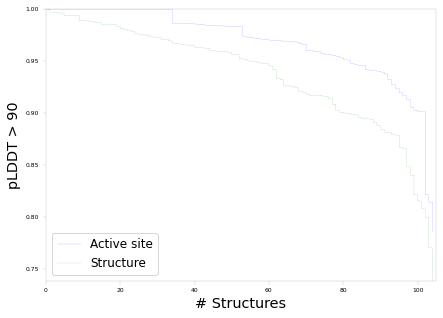

In [35]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
def CDF(data, color, label):
    values, base = np.histogram(data, bins=10000)
    cumulative = np.cumsum(np.histogram(data, bins=10000)[0])
    # plt.plot(len(data)-cumulative, base[:-1], c=color)
    plt.plot(len(data)-cumulative,
              base[:-1],
             c=color, label = label)
    
CDF(ppdsite_perc, 'blue', 'Active site')
CDF(perc, 'green', 'Structure')
plt.legend(fontsize='large')
plt.ylabel('pLDDT > 90', size='x-large')
plt.ylim([
    min(perc+ppdsite_perc),
    # 0.5,
          1])
# plt.xticklabels(size='large')
plt.xlabel('# Structures', size='x-large')
plt.xlim([0,max(len(perc), len(ppdsite_perc))])
fig.savefig('Supplementary_Fig_1.pdf')

## Count structure by stoihchiometry

In [37]:
coo = pd.read_table('../../PLP_enzymes/Homo_sapiens/AF_db/Homo_sapiens_coord.csv')
coo[~coo['pdb'].str.contains('MANUAL')].groupby('uniprot_ac').count().groupby('lys').count()

,pdb,chain,res,x,y,z
lys,,,,,,
0,3,3,3,3,3,3
1,3,3,3,3,3,3
2,39,39,39,39,39,39
4,8,8,8,8,8,8


In [38]:
coo = pd.read_table('../../PLP_enzymes/Mus_musculus/AF_db/Mus_musculus_coord.csv')
coo[~coo['pdb'].str.contains('MANUAL')].groupby('uniprot_ac').count().groupby('lys').count()

,pdb,chain,res,x,y,z
lys,,,,,,
0,3,3,3,3,3,3
1,5,5,5,5,5,5
2,41,41,41,41,41,41
4,5,5,5,5,5,5


# Supplementary Fig. 5

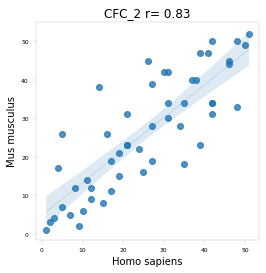

In [39]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

cols = [
    'CFC_2'
                # 'ade_mean_BC',
                # 'ade_mean_LC',
                # 'affinity_BC',
                # 'affinity_LC',
                # 'runs_BC',
                # 'runs_LC',
                ]
lig = 'HTL'
col = 'CFC_2'

df_homo = pd.read_table(f'Fig_4/rank_Homo_sapiens_{lig}.tsv')
df_homo['Gene name'] = df_homo['Gene names'].apply(lambda x: x.split(' ')[0].lower().capitalize())
df_homo = df_homo[df_homo['ranking']==col]
df_homo = df_homo[['rank','Gene name']]
df_homo = df_homo.rename(columns={'rank':'Homo sapiens'})

df_mus = pd.read_table(f'Fig_4/rank_Mus_musculus_{lig}.tsv')
df_mus['Gene name'] = df_mus['Gene names'].apply(lambda x: x.split(' ')[0].lower().capitalize())
df_mus = df_mus[df_mus['ranking']==col]
df_mus = df_mus[['rank','Gene name']]
df_mus = df_mus.rename(columns={'rank':'Mus musculus'})
data = pd.merge(df_homo, df_mus, 
                            # on='Gene name'
                           )
reg = sns.regplot(data = data,
                x='Homo sapiens',
                y='Mus musculus',
                ax=ax,
                fit_reg=True,
                # hue='ranking',
               )

ax.set_title(f"{col} r= {round(data.corr().min().min(),2)}")
# # df_homo
data.corr('spearman').min().min()
fig.savefig('Supplementary_Fig_5.pdf')

# Supplementary Fig. 10

## SHMT1

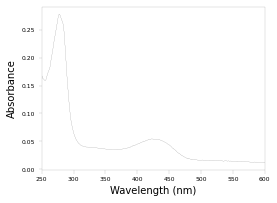

In [40]:
df = pd.read_table('Supplementary_Fig_10/shmt1.txt',skiprows=1, header=None)
df = df[df[0].between(250,600)]
fig = spectra(df)
fig.savefig('shmt1_spectrum.pdf')

## SHMT2

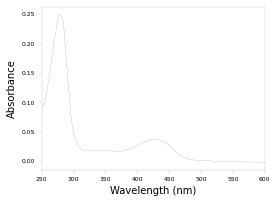

In [41]:
df = pd.read_table('Supplementary_Fig_10/shmt2.txt',skiprows=1, header=None)
df = df[df[0].between(250,600)]
fig = spectra(df)
fig.savefig('shmt2_spectrum.pdf')

## KYAT1

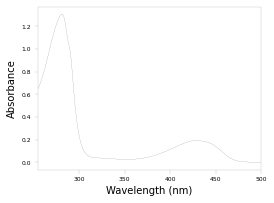

In [42]:
df = pd.read_csv('Supplementary_Fig_10/kyat1_purificata.csv', header=None, sep =',')
df = df.drop(df.index[0:1]).iloc[18:-44].astype(float)
fig = spectra(df)
fig.savefig('kyat1_spectrum.pdf')

## Kyat3

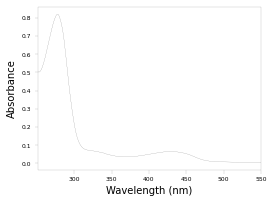

In [43]:
df = pd.read_csv('Supplementary_Fig_10/spettro_kyat3_01-03-2021.csv', header=None, sep =',')
df = df.drop(df.index[0:1]).iloc[18:-44].astype(float)
fig = spectra(df)
fig.savefig('kyat3_spectrum.pdf')

## SGPL1

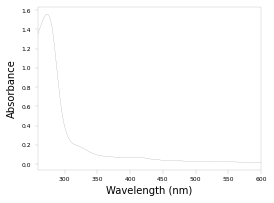

In [44]:
df = pd.read_csv('Supplementary_Fig_10/sgpl1_purificata.csv', header=None, sep =',')
df = df.drop(df.index[0:1]).iloc[18:-44].astype(float)
fig = spectra(df)
fig.savefig('sgpl1_spectrum.pdf')

## Tha1

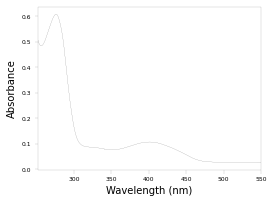

In [45]:
df = pd.read_csv('Supplementary_Fig_10/spettroTHA_24_2_21_10h.csv', header=None, sep =',')
df = df.drop(df.index[0:1]).iloc[18:-44].astype(float)
fig = spectra(df)
fig.savefig('tha1_spectrum.pdf')

# Supplementary Fig. 14

## Supplementary Fig. 14a

Enzyme: **Tha1** <br>
Substrate: **HTML (mM)** <br>
Enzyme concentration: **1 µM** <br>
Temperature: **30°C**

$k_{cat}$ = 2.311 ± 0.029 s⁻¹ <br> $K_{M}$ = 0.169 ± 0.009 mM <br> $k_{cat}$/$K_{M}$ = 13695.069 ± 892.495 M⁻¹s⁻¹ <br> R² = 0.993

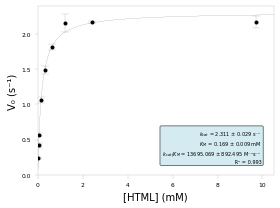

In [46]:
df = pd.read_csv('Fig_5/tha_mus/HTML/vmax.csv', sep = ',',
                 comment = '#',
                )
df['bo'] = df['input'].apply(lambda x : os.path.basename(x)
                           .split('_')[2] ## condition separator in file name
                           .split('m')[0]) # m or u for mM or uM
p = df[['vmax', 'bo']].groupby('bo').agg({'vmax':['mean','sem']})
p['substrate'] = p.index
p = (p.astype(float)
     .sort_values('substrate')
    )
x, y = p['substrate'], p['vmax']['mean']
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['vmax']['sem'], 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[HTML] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')
ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=5,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.plot(toplot, MM(toplot, *popt), 'black')
fig.tight_layout()

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14a.pdf', dpi=600)


## Supplementary Fig. 14b

Enzyme: **Tha1** <br>
Substrate: **L-allo-threonine (mM)** <br>
Enzyme concentration: **1 µM** <br>
Temperature: **30°C**

$k_{cat}$ = 1.96 ± 0.039 s⁻¹ <br> $K_{M}$ = 8.236 ± 0.496 mM <br> $k_{cat}$/$K_{M}$ = 238.005 ± 19.055 M⁻¹s⁻¹ <br> R² = 0.993

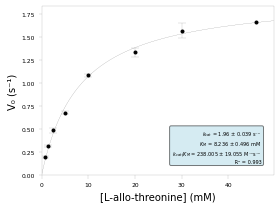

In [47]:
df = pd.read_csv('Fig_5/tha_mus/allo_THR/vmax.csv', sep = ',',
#                  header = None,
                 comment = '#',
#                  names = ['exp', 'v']
                )
df['bo'] = df['input'].apply(lambda x : os.path.basename(x)
                           .split('_')[2] ## condition separator in file name
                           .split('m')[0]) # m or u for mM or uM
p = df[['vmax', 'bo']].groupby('bo').agg({'vmax':['mean','sem']})
p['substrate'] = p.index
p = (p.astype(float)
     .sort_values('substrate')
#      .drop(index = '750')
    )
x, y = p['substrate'], p['vmax']['mean']
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['vmax']['sem'], 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-allo-threonine] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')
ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=5,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.plot(toplot, MM(toplot, *popt), 'black')
fig.tight_layout()

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14b.pdf', dpi=600)


## Supplementary Fig. 14c

Enzyme: **Tha1** <br>
Substrate: **L-threonine (mM)** <br>
Enzyme concentration: **1 µM** <br>
Temperature: **30°C**

$k_{cat}$ = 0.375 ± 0.024 s⁻¹ <br> $K_{M}$ = 37.531 ± 6.278 mM <br> $k_{cat}$/$K_{M}$ = 10.005 ± 2.304 M⁻¹s⁻¹ <br> R² = 0.959

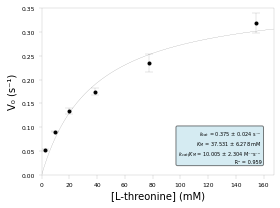

In [48]:
df = pd.read_csv('Fig_5/tha_mus/THR/vmax.csv', sep = ',',
#                  header = None,
                 comment = '#',
#                  names = ['exp', 'v']
                )
df['bo'] = df['input'].apply(lambda x : os.path.basename(x)
                           .split('_')[2] ## condition separator in file name
                           .split('m')[0]) # m or u for mM or uM
p = df[['vmax', 'bo']].groupby('bo').agg({'vmax':['mean','sem']})
p['substrate'] = p.index
p = (p.astype(float)
     .sort_values('substrate')
#      .drop(index = '750')
    )
x, y = p['substrate'], p['vmax']['mean']
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['vmax']['sem'], 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-threonine] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')

ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=5,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.plot(toplot, MM(toplot, *popt), 'black')
fig.tight_layout()

printmd(result.replace('\n', '<br>'))

fig.savefig(f'Supplementary_Fig_14c.pdf', dpi=600)


## Supplementary Fig. 14d

Enzyme: **SHMT1** <br>
Substrate: **L-allo-threonine (mM)** <br>
Enzyme concentration: **0.15 µM** <br>
Temperature: **37°C**

$k_{cat}$ = 2.365 ± 0.021 s⁻¹ <br> $K_{M}$ = 0.226 ± 0.01 mM <br> $k_{cat}$/$K_{M}$ = 10481.813 ± 562.441 M⁻¹s⁻¹ <br> R² = 0.994

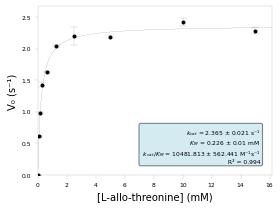

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

p = pd.read_table('Fig_5/MM_SHMT1_allothr.tsv')
x, y = p['mM'], p['mean']/60/0.15
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['SEM']/60/0.15, 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-allo-threonine] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff

result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')

ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=6,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.tight_layout()
plt.plot(toplot, MM(toplot, *popt), 'black')

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14d.pdf', 
            dpi=600
           )


## Supplementary Fig. 14e

Enzyme: **SHMT2** <br>
Substrate: **L-allo-threonine (mM)** <br>
Enzyme concentration: **1 µM** <br>
Temperature: **37°C**

$k_{cat}$ = 0.311 ± 0.004 s⁻¹ <br> $K_{M}$ = 1.345 ± 0.066 mM <br> $k_{cat}$/$K_{M}$ = 231.56 ± 14.594 M⁻¹s⁻¹ <br> R² = 0.995

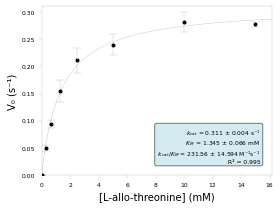

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

p = pd.read_table('Fig_5/MM_SHMT2_allothr.tsv')
x, y = p['mM'], p['mean']/60
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['SEM']/60, 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-allo-threonine] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')

ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=6,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.tight_layout()
plt.plot(toplot, MM(toplot, *popt), 'black')

printmd(result.replace('\n', '<br>'))

fig.savefig(f'Supplementary_Fig_14e.pdf', 
            dpi=600
           )


## Supplementary Fig. 14f

Enzyme: **eTA** <br>
Substrate: **L-allo-threonine (µM)** <br>
Enzyme concentration: **0.1 µM** <br>
Temperature: **30°C**

$k_{cat}$ = 4.021 ± 0.124 s⁻¹ <br> $K_{M}$ = 52.56 ± 6.28 µM <br> $k_{cat}$/$K_{M}$ = 76509.204 ± 11498.796 M⁻¹s⁻¹ <br> R² = 0.961

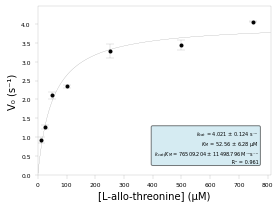

In [51]:
df = pd.read_csv('Fig_5/tha_coli/allo_THR/vmax.csv', sep = ',',
#                  header = None,
                 comment = '#',
#                  names = ['exp', 'v']
                )
df['bo'] = df['input'].apply(lambda x : os.path.basename(x)
                           .split('_')[2] ## condition separator in file name
                           .split('u')[0]) # m or u for mM or uM
p = df[['vmax', 'bo']].groupby('bo').agg({'vmax':['mean','sem']})
p['substrate'] = p.index
p = (p.astype(float)
     .sort_values('substrate')
#      .drop(index = '750')
    )
x, y = p['substrate'], p['vmax']['mean']
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['vmax']['sem'], 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-allo-threonine] ({chr(956)}M)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='µM')

ax.text(0.95, 0.07, result, transform=ax.transAxes, 
        fontsize=5,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.plot(toplot, MM(toplot, *popt), 'black')
fig.tight_layout()

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14f.pdf', dpi=600)


## Supplementary Fig. 14g

Enzyme: **SHMT2** <br>
Substrate: **HTML (mM)** <br>
Enzyme concentration: **4 µM** <br>
Temperature: **37°C**

$k_{cat}$ = 0.005 ± 0.0 s⁻¹ <br> $K_{M}$ = 0.803 ± 0.067 mM <br> $k_{cat}$/$K_{M}$ = 6.311 ± 0.674 M⁻¹s⁻¹ <br> R² = 0.986

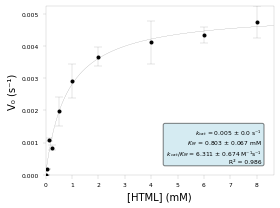

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

p = pd.read_table('Fig_5/MM_SHMT2_html.tsv')
x, y = p['mM'], p['mean']/60/4
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['SEM']/60/4, 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[HTML] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')
ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=6,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.tight_layout()
plt.plot(toplot, MM(toplot, *popt), 'black')

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14g.pdf', 
            dpi=600
           )


## Supplementary Fig. 14h

Enzyme: **eTA** <br>
Substrate: **HTML (µM)** <br>
Enzyme concentration: **1 µM** <br>
Temperature: **30°C**

$k_{cat}$ = 3.882 ± 0.066 s⁻¹ <br> $K_{M}$ = 70.133 ± 4.087 µM <br> $k_{cat}$/$K_{M}$ = 55349.492 ± 4171.152 M⁻¹s⁻¹ <br> R² = 0.992

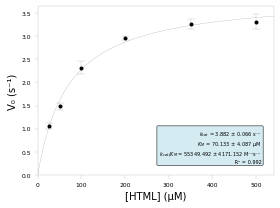

In [53]:
df = pd.read_csv('Fig_5/tha_coli/HTML/vmax.csv', sep = ',',
#                  header = None,
                 comment = '#',
#                  names = ['exp', 'v']
                )
df['bo'] = df['input'].apply(lambda x : os.path.basename(x)
                           .split('_')[2] ## condition separator in file name
                           .split('u')[0]) # m or u for mM or uM
p = df[['vmax', 'bo']].groupby('bo').agg({'vmax':['mean','sem']})
p['substrate'] = p.index
p = (p.astype(float)
     .sort_values('substrate')
#      .drop(index = '750')
    )
x, y = p['substrate'], p['vmax']['mean']
# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['vmax']['sem'], 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[HTML] ({chr(956)}M)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='µM')
ax.text(0.95, 0.07, result, transform=ax.transAxes, 
        fontsize=5,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.plot(toplot, MM(toplot, *popt), 'black')
fig.tight_layout()

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14h.pdf', dpi=600)


## Supplementary Fig. 14i

Enzyme: **SHMT1** <br>
Substrate: **L-threonine (mM)** <br>
Enzyme concentration: **1.63 µM** <br>
Temperature: **37°C**

$k_{cat}$ = 0.154 ± 0.003 s⁻¹ <br> $K_{M}$ = 36.522 ± 1.434 mM <br> $k_{cat}$/$K_{M}$ = 4.208 ± 0.242 M⁻¹s⁻¹ <br> R² = 0.998

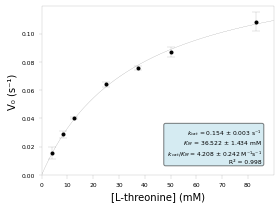

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
p = pd.read_table('Fig_5/MM_SHMT1_thr.tsv')
p['v0'] = p.apply(lambda x: [x[1], x[2]], axis=1)
p = p.explode('v0')[['mM', 'v0']]
p = p.groupby('mM').agg(['mean','sem']).reset_index()
x, y = p['mM'], p['v0']['mean']/1.63

# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['v0']['sem']/1.63, 
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-threonine] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')
ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=6,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.tight_layout()
plt.plot(toplot, MM(toplot, *popt), 'black')

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14i.pdf', 
            dpi=600
           )


## Supplementary Fig.14j

Enzyme: **SHMT2** <br>
Substrate: **L-threonine (mM)** <br>
Enzyme concentration: **5.68 µM** <br>
Temperature: **37°C**

$k_{cat}$ = 0.035 ± 0.001 s⁻¹ <br> $K_{M}$ = 41.224 ± 1.979 mM <br> $k_{cat}$/$K_{M}$ = 0.846 ± 0.06 M⁻¹s⁻¹ <br> R² = 0.997

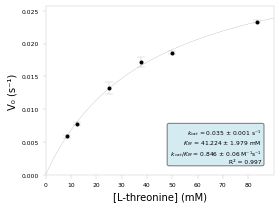

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
p = pd.read_table('Fig_5/MM_SHMT2_thr.tsv')
p['v0'] = p.apply(lambda x: [x[1], x[2]], axis=1)
p = p.explode('v0')[['mM', 'v0']]
p = p.groupby('mM').agg(['mean','sem']).reset_index()
x, y = p['mM'], p['v0']['mean']/5.68

# plt.rcParams.update({'font.family':'serif'})
popt, pcov = curve_fit(MM, x, y)
perr = np.sqrt(np.diag(pcov))/ np.sqrt(3)

residuals = y - MM(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)

toplot = np.arange(0, x.max()+(x.max()*0.1), (x.max()-x.min())/10000)

ax.errorbar(x, y, yerr=p['v0']['sem']/5.68,
            fmt='o', capsize = 4, color = 'black', ms=3, capthick=.1
           )
ax.set_xlim([0,
              x.max()+(x.max()*0.08)])
ax.set_ylim([0,
              y.max()+(y.max()*0.1)])

ax.set_xlabel(f'[L-threonine] (mM)')
ax.set_ylabel('V\N{SUBSCRIPT zero} (s\u207b\N{SUPERSCRIPT one})')
cat_eff = popt[0]/popt[1] *1000
cat_eff_error = (perr[0]/popt[0] + perr[1]/popt[1]) * cat_eff
result = legendMM(popt, perr, cat_eff, cat_eff_error, R2, unit='mM')

ax.text(0.95, 0.07, result, transform=ax.transAxes, fontsize=6,
        horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
fig.tight_layout()
plt.plot(toplot, MM(toplot, *popt), 'black')

printmd(result.replace('\n', '<br>'))
fig.savefig(f'Supplementary_Fig_14j.pdf', 
            dpi=600
           )


# Supplementary Fig. 15b,c

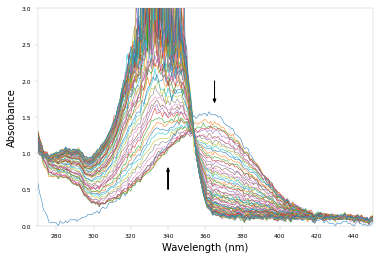

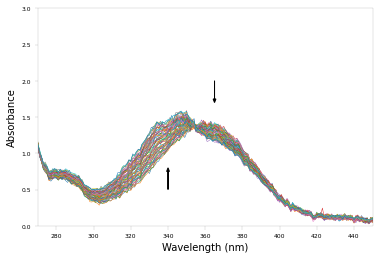

In [56]:
df1 = pd.read_csv('Supplementary_Fig_15/kynu+html1.csv', sep='\t', header=None).dropna(axis=1, how='all') 
df2 = pd.read_csv('Supplementary_Fig_15/kynu+html2.csv', sep='\t', header=None).dropna(axis=1, how='all')
df3 = pd.read_csv('Supplementary_Fig_15/kynu+html3.csv', sep='\t', header=None).dropna(axis=1, how='all')
ddf1 = pd.read_csv('Supplementary_Fig_15/kynu+tris_20mM.csv', sep='\t', header=None).dropna(axis=1, how='all') 
ddf2 = pd.read_csv('Supplementary_Fig_15/kynu+tris_20mM1.csv', sep='\t', header=None).dropna(axis=1, how='all')
df = pd.concat([df1,df2,df3], axis=1, ignore_index=True).reindex(df1.index)
df1 = pd.concat([ddf1,ddf2], axis=1, ignore_index=True).reindex(df1.index)

# without HTML
fig, ax = plot_kin(df1)
fig.savefig('Supplementary_Fig_15_b.pdf')

# with HTML
fig, ax = plot_kin(df)
fig.savefig('Supplementary_Fig_15_c.pdf')

# Supplementary Fig. 16

In [58]:
coord = pd.concat([pd.read_table('Supplementary_Table_1/Homo_sapiens_coord.tsv'), pd.read_table('Supplementary_Table_1/Mus_musculus_coord.tsv')])
coord = coord[['uniprot_ac', 'res']].dropna()
coord['res'] = coord['res'].astype(int)
coords = dict(coord[['uniprot_ac', 'res']].dropna().values)
len(coords)

105

### Decomment cell below to generate `Supplementary_Fig_16/RMSD.tsv` file

In [59]:
# templates = []
# ALPHAFOLD = True
# rmsd_df = []
# for ac in coords.keys():
#     # if ac not in s_list:
#     try:
#         j = json.load(urllib.request.urlopen(f'https://swissmodel.expasy.org/repository/uniprot/{ac}.json'))['result']['structures']
#         time.sleep(0.1)    
#         try:
#             pdbs = pd.json_normalize([x for x in j if 'homo' in x['oligo-state']], max_level=0)
#         except:
#             pdbs = pd.json_normalize([x for x in j], max_level=0)
#         for i,pdb in pdbs.iterrows():
#             pdb = pd.DataFrame(pdb).T
#             pdb.index = [ac]
#             name = f"{ac}_{pdb['provider'][0]}"
#             TEMPLATE = pdb['template'].iloc[0].split('.')[0]

#             if ALPHAFOLD:
#                 rmsd = build_homoligo(f'https://alphafold.ebi.ac.uk/files/AF-{ac}-F1-model_v4.pdb', 
#                                       # f"https://files.rcsb.org/view/{TEMPLATE}.pdb",
#                                       pdb['coordinates'][0], 
#                                       coords,
#                                       name)
#                 rmsd[['ac','provider']] =  [ac, pdb['provider'][0]]
#                 rmsd_df.append(rmsd)
#             else:
#                 urllib.request.urlretrieve(pdb['coordinates'][0], f"{name}.pdb")
#             templates.append(pdb.reset_index())
#             printmd(f"{name} as **{pdb['oligo-state'][0].upper()}**")
#     except:
#         templates.append(pd.DataFrame([], index=[ac], columns=['provider']))
#         printmd(f"{ac} not found")

# rmsd_df = pd.concat(rmsd_df)
# rmsd_df.to_csv('Supplementary_Fig_16/RMSD.tsv', index=None, sep='\t')


P00505_PDB as **HOMO-2-MER**

P00505_SWISSMODEL as **HOMO-2-MER**

Q05329_PDB as **HOMO-2-MER**

Q05329_SWISSMODEL as **HOMO-2-MER**

Q96I15_PDB as **HOMO-2-MER**

Q96I15_PDB as **HOMO-2-MER**

Q96I15_SWISSMODEL as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_PDB as **HOMO-2-MER**

Q9GZT4_SWISSMODEL as **HOMO-2-MER**

Q9Y600_PDB as **HOMO-2-MER**

Q9Y600_SWISSMODEL as **HOMO-2-MER**

P17174_PDB as **HOMO-2-MER**

P17174_PDB as **HOMO-2-MER**

P17174_SWISSMODEL as **HOMO-2-MER**

Q96QU6_SWISSMODEL as **HOMO-2-MER**

Q96QU6_SWISSMODEL as **HOMO-2-MER**

Q6ZQY3_SWISSMODEL as **HOMO-2-MER**

Q4AC99_SWISSMODEL as **HOMO-2-MER**

Q4AC99_SWISSMODEL as **HOMO-2-MER**

P34896_PDB as **HOMO-4-MER**

P34896_PDB as **HOMO-4-MER**

P34896_PDB as **HOMO-4-MER**

P34896_SWISSMODEL as **HOMO-4-MER**

P04181_PDB as **HOMO-4-MER**

P04181_PDB as **HOMO-3-MER**

P04181_PDB as **HOMO-3-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_PDB as **HOMO-2-MER**

P04181_SWISSMODEL as **HOMO-2-MER**

P20132_SWISSMODEL as **HOMO-2-MER**

P17735_PDB as **HOMO-2-MER**

P17735_SWISSMODEL as **HOMO-2-MER**

P17735_SWISSMODEL as **HOMO-2-MER**

P17735_SWISSMODEL as **HOMO-2-MER**

Q96GA7_PDB as **HOMO-2-MER**

Q96GA7_SWISSMODEL as **HOMO-2-MER**

Q96EN8_SWISSMODEL as **HOMO-2-MER**

O95470_PDB as **HOMO-2-MER**

O95470_SWISSMODEL as **HOMO-2-MER**

Q8IUZ5_SWISSMODEL as **HOMO-2-MER**

Q9HD40_PDB as **HOMO-4-MER**

Q9HD40_PDB as **HOMO-4-MER**

Q9HD40_PDB as **HOMO-4-MER**

Q9HD40_PDB as **HOMO-4-MER**

Q9HD40_PDB as **HOMO-4-MER**

Q9HD40_PDB as **HOMO-4-MER**

Q9HD40_SWISSMODEL as **HOMO-4-MER**

P13196_SWISSMODEL as **HOMO-2-MER**

P80404_SWISSMODEL as **HOMO-2-MER**

P24298_SWISSMODEL as **HOMO-2-MER**

P24298_SWISSMODEL as **HOMO-2-MER**

Q16719_PDB as **HOMO-2-MER**

Q16719_PDB as **HOMO-2-MER**

Q16719_PDB as **HOMO-2-MER**

Q16719_SWISSMODEL as **HOMO-2-MER**

Q9BYV1_SWISSMODEL as **HOMO-2-MER**

Q9BYV1_SWISSMODEL as **HOMO-2-MER**

O75600_SWISSMODEL as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_PDB as **HOMO-2-MER**

O15382_SWISSMODEL as **HOMO-2-MER**

P23378_PDB as **HOMO-2-MER**

P23378_PDB as **HOMO-2-MER**

P23378_PDB as **HOMO-2-MER**

P23378_SWISSMODEL as **HOMO-2-MER**

P11217_PDB as **HOMO-2-MER**

P11217_SWISSMODEL as **HOMO-2-MER**

P11217_SWISSMODEL as **HOMO-2-MER**

P11216_PDB as **HOMO-4-MER**

P11216_SWISSMODEL as **HOMO-2-MER**

Q9Y617_PDB as **HOMO-8-MER**

Q9Y617_PDB as **HOMO-2-MER**

Q9Y617_PDB as **HOMO-2-MER**

Q9Y617_SWISSMODEL as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_PDB as **HOMO-2-MER**

Q16773_SWISSMODEL as **HOMO-2-MER**

Q16773_SWISSMODEL as **HOMO-2-MER**

P06737_PDB as **HOMO-4-MER**

P06737_PDB as **HOMO-4-MER**

P06737_PDB as **HOMO-4-MER**

P06737_PDB as **HOMO-4-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_PDB as **HOMO-2-MER**

P06737_SWISSMODEL as **HOMO-2-MER**

P06737_SWISSMODEL as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_PDB as **HOMO-2-MER**

P22557_SWISSMODEL as **HOMO-2-MER**

Q8TBG4_PDB as **HOMO-2-MER**

Q8TBG4_SWISSMODEL as **HOMO-2-MER**

Q8TBG4_SWISSMODEL as **HOMO-2-MER**

P34897_PDB as **HOMO-4-MER**

P34897_PDB as **HOMO-4-MER**

P34897_PDB as **HOMO-4-MER**

P34897_PDB as **HOMO-2-MER**

P34897_PDB as **HOMO-2-MER**

P34897_PDB as **HOMO-2-MER**

P34897_PDB as **HOMO-2-MER**

P34897_PDB as **HOMO-2-MER**

P34897_PDB as **HOMO-2-MER**

P34897_SWISSMODEL as **HOMO-2-MER**

P20711_PDB as **HOMO-2-MER**

P20711_PDB as **HOMO-2-MER**

P20711_PDB as **HOMO-2-MER**

P20711_SWISSMODEL as **HOMO-2-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_PDB as **HOMO-4-MER**

P32929_SWISSMODEL as **HOMO-4-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_PDB as **HOMO-2-MER**

P21549_SWISSMODEL as **HOMO-2-MER**

Q8NHS2_SWISSMODEL as **HOMO-2-MER**

Q99259_PDB as **HOMO-2-MER**

Q99259_PDB as **HOMO-2-MER**

Q99259_SWISSMODEL as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_PDB as **HOMO-2-MER**

P11926_SWISSMODEL as **HOMO-2-MER**

P19113_PDB as **HOMO-2-MER**

P19113_PDB as **HOMO-2-MER**

P19113_PDB as **HOMO-2-MER**

P19113_PDB as **HOMO-2-MER**

P19113_SWISSMODEL as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-4-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_PDB as **HOMO-2-MER**

Q8N5Z0_SWISSMODEL as **HOMO-2-MER**

Q8N5Z0_SWISSMODEL as **HOMO-2-MER**

Q6YP21_SWISSMODEL as **HOMO-2-MER**

Q6YP21_SWISSMODEL as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_PDB as **HOMO-2-MER**

P35520_SWISSMODEL as **HOMO-2-MER**

P35520_SWISSMODEL as **HOMO-2-MER**

 ExecutiveAlign: mobile selection must derive from one object only.


P35520 not found

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_PDB as **HOMO-2-MER**

P54687_SWISSMODEL as **HOMO-2-MER**

Q8TD30_SWISSMODEL as **HOMO-2-MER**

Q9ET01_SWISSMODEL as **HOMO-2-MER**

Q9ET01_SWISSMODEL as **HOMO-2-MER**

P05202_PDB as **HOMO-2-MER**

P05202_PDB as **HOMO-2-MER**

P05202_PDB as **HOMO-2-MER**

P05202_SWISSMODEL as **HOMO-2-MER**

Q3UEG6_SWISSMODEL as **HOMO-2-MER**

Q9CZN7_SWISSMODEL as **HOMO-2-MER**

P00860_PDB as **HOMO-2-MER**

P00860_SWISSMODEL as **HOMO-2-MER**

Q8CI94_SWISSMODEL as **HOMO-2-MER**

Q9JLI6_SWISSMODEL as **HOMO-2-MER**

Q7TSV6_SWISSMODEL as **HOMO-2-MER**

Q9QZX7_SWISSMODEL as **HOMO-2-MER**

Q8R1K4_SWISSMODEL as **HOMO-2-MER**

Q8R1K4_SWISSMODEL as **HOMO-4-MER**

Q9CXF0_SWISSMODEL as **HOMO-2-MER**

Q8QZR5_SWISSMODEL as **HOMO-2-MER**

Q8QZR5_SWISSMODEL as **HOMO-2-MER**

Q6XPS7_SWISSMODEL as **HOMO-4-MER**

Q6XPS7_SWISSMODEL as **HOMO-4-MER**

Q91W43_SWISSMODEL as **HOMO-2-MER**

P61922_SWISSMODEL as **HOMO-2-MER**

Q14CH1_SWISSMODEL as **HOMO-2-MER**

Q14CH1_SWISSMODEL as **HOMO-2-MER**

Q8VCN5_SWISSMODEL as **HOMO-4-MER**

Q3UX83_SWISSMODEL as **HOMO-2-MER**

Q3UX83_SWISSMODEL as **HOMO-2-MER**

Q6P6M7_PDB as **HOMO-4-MER**

Q6P6M7_PDB as **HOMO-4-MER**

Q6P6M7_PDB as **HOMO-4-MER**

Q6P6M7_SWISSMODEL as **HOMO-4-MER**

P24288_SWISSMODEL as **HOMO-2-MER**

A2AIG8_SWISSMODEL as **HOMO-2-MER**

P05201_SWISSMODEL as **HOMO-2-MER**

P48318_SWISSMODEL as **HOMO-2-MER**

Q8BWU8_SWISSMODEL as **HOMO-2-MER**

Q8BWU8_SWISSMODEL as **HOMO-2-MER**

Q8VC19_SWISSMODEL as **HOMO-2-MER**

Q8QZR1_PDB as **HOMO-2-MER**

Q8QZR1_SWISSMODEL as **HOMO-2-MER**

Q8QZR1_SWISSMODEL as **HOMO-2-MER**

O35855_SWISSMODEL as **HOMO-2-MER**

Q9WUB3_SWISSMODEL as **HOMO-2-MER**

Q9WUB3_SWISSMODEL as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_PDB as **HOMO-2-MER**

Q71RI9_SWISSMODEL as **HOMO-2-MER**

Q71RI9_SWISSMODEL as **HOMO-2-MER**

Q8R0X7_SWISSMODEL as **HOMO-2-MER**

Q8BGT5_SWISSMODEL as **HOMO-2-MER**

Q8BGT5_SWISSMODEL as **HOMO-2-MER**

P23738_SWISSMODEL as **HOMO-2-MER**

Q80WP8_PDB as **HOMO-2-MER**

Q80WP8_SWISSMODEL as **HOMO-2-MER**

P08680_SWISSMODEL as **HOMO-2-MER**

Q9DBE0_PDB as **HOMO-2-MER**

Q9DBE0_PDB as **HOMO-2-MER**

Q9DBE0_SWISSMODEL as **HOMO-2-MER**

Q8BTY1_SWISSMODEL as **HOMO-2-MER**

Q99K85_SWISSMODEL as **HOMO-2-MER**

O35423_PDB as **HOMO-2-MER**

O35423_PDB as **HOMO-2-MER**

O35423_SWISSMODEL as **HOMO-2-MER**

O88533_SWISSMODEL as **HOMO-2-MER**

P29758_SWISSMODEL as **HOMO-2-MER**

P29758_SWISSMODEL as **HOMO-2-MER**

Q8R238_SWISSMODEL as **HOMO-2-MER**

P50431_PDB as **HOMO-4-MER**

P50431_SWISSMODEL as **HOMO-4-MER**

Q91WT9_SWISSMODEL as **HOMO-2-MER**

Q91WT9_SWISSMODEL as **HOMO-2-MER**

P48320_SWISSMODEL as **HOMO-2-MER**

O88986_SWISSMODEL as **HOMO-2-MER**

Q9WVM8_SWISSMODEL as **HOMO-2-MER**

Q9WVM8_SWISSMODEL as **HOMO-2-MER**

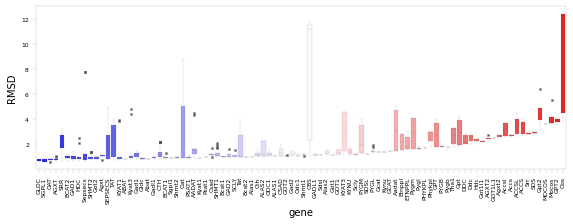

In [60]:
rm = pd.read_table('Supplementary_Fig_16/RMSD.tsv')
rm = rm.rename(columns={'0':'RMSD', '7':'Active Site RMSD'})
proteome = pd.concat([pd.read_table('Supplementary_Table_1/Homo_sapiens_uniprot.tsv'),
                      pd.read_table('Supplementary_Table_1/Mus_musculus_uniprot.tsv')
                     ]).fillna('')
proteome['Gene name'] = proteome['Gene names'].apply(lambda x: x.split(' ')[0]) # get only first name
gene_name = dict(proteome[['Entry', 'Gene name']].values) # create dict uniprotac : gene name

rm['gene'] = rm['ac'].apply(lambda x: gene_name.get(x)) #create column with gene name

col = 'RMSD'
# col = 'Active Site RMSD'
ac_ord = {n:i+1 for i,n in enumerate(rm.groupby('ac').min().sort_values(col, ascending=True).reset_index()['ac'].to_list())}
# rm.groupby('ac').mean().sort_values(7, ascending=False).reset_index()

rm['ord'] = rm['ac'].apply(lambda x: ac_ord.get(x))
rm = rm.sort_values('ord')
fig, ax = plt.subplots(1,1, figsize=(9.5,3))
ax.set_xlabel('Gene',)
ax.set_ylabel(col, )
plt.xticks(rotation=90)
# ax.set_ylim([0,8])
sns.boxplot(data=rm, x='gene', y=col, 
            # whis=20, ,
            flierprops={"marker": "x", 'linewidth':.2},
            fliersize=2,
            palette='bwr',
            # labels=rm['ac']
           )
# ax.set_yscale('log')
fig.savefig('Supplementary_Fig_16.pdf')
# fig.savefig('RMSD_site.pdf')



# Supplementary Fig. 18

## Supplementary Fig. 18b,d

Supplementary_Fig_18/HTL_PLP_Q6XPS7_tha_template_padova_only_tetramero_B
Supplementary_Fig_18/HTL_PLP_Q6XPS7_tha_template_padova_tetramero_B


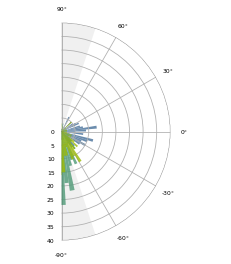

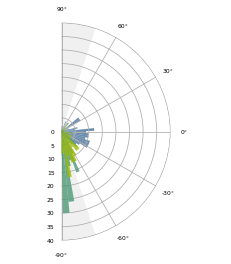

In [61]:
reactions = ['X1', 'X2', 'X3']
for DIR in glob.glob('Supplementary_Fig_18/HTL_PLP*'):
    print(DIR)
    fig, ax = plt.subplots(1,1, 
                             figsize=(4,4), 
                             subplot_kw={'projection': 'polar'}) 
    sw_list = []
    for x in glob.glob(f'{DIR}/*.pdbqt'):
        sw_list.append(calc_run_polar(x,eval(open('Fig_6/HTL_PLP.txt').read())))
    swar = pd.concat(sw_list)    
    swar
    # swar = pd.concat([calc_run_polar(x,eval(open('Fig_6/HTL_PLP.txt').read())) 
    #                   for x in glob.glob(f"{DIR}/.pdbqt")])
    dfs = []
    lims = []
    for col, color, size in zip(reactions,
                   ['#467099ff', '#4e9976ff', '#99b802ff'],
                   [1,2,3],
                             # axes
                                   ):

        ax.set_xticklabels(['0', '45', '90', '45', '0', '-45', '-90', '-45', ])
        ax.set_xticklabels(reversed(['90°', '60°', '30°', '0°', '-30°', '-60°', '-90°',]))
        ax.set_ylim([0,40])

        # df = swar[[col]]*np.pi*2
        df = swar[[col]].apply(lambda x: np.arcsin(x))
        df = df.rename(columns={col:'angle'})
        df['kind'] = col#[-2]
        df['y'] = 'prova'
        dfs.append(df)
        # ax.set_rticks([])
        lims.append(ax.get_ylim()[1])


        ax.hist(df['angle']*np.pi/2,
                 bins=50,
                 color=color,
                alpha=0.8,
                zorder=size,
                align='right',
                )
        # plt.yticks(fontsize='x-large')
        # plt.xticks(fontsize='x-large')
    ax.bar([np.pi/2, np.pi*1.5], [max(lims)]*2, [(np.pi/2-np.arcsin(0.95))*2]*2, alpha=0.33, bottom=0, color='lightgrey', zorder=0,
           align='center'
          )
    ax.set_thetamin(-90)
    ax.set_thetamax(90)
    # ax.ThetaDir = 'clockwise'
    panel = 'd' if 'only' in DIR else 'b' 
    fig.savefig(f'Supplementary_Fig_18_{panel}.pdf')
    # fig.savefig('HTL_PLP_Q6XPS7_tha_template_padova_only_tetramero_B_polar_plot.pdf')
    # fig.savefig('HTL_PLP_Q6XPS7_tha_template_padova_tetramero_B_polar_plot.pdf')
    # fig.savefig('Tha1_F222_refine_63_Parma2_Tetramero_B_polar_plot.pdf')
    fig

## Supplementary Fig. 18b,d

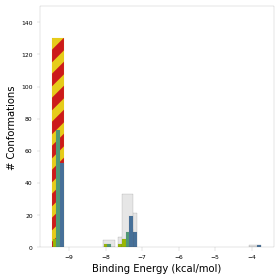

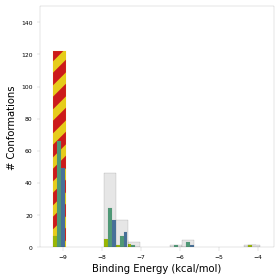

In [62]:
for df in glob.glob('Supplementary_Fig_18/*.tsv'):
    panel = 'c' if 'only' in df else 'a'
    histo = pd.read_table(df)
    fig, ax = plothisto(histo, R=True)
    fig.savefig(f'Supplementary_Fig_18_{panel}.pdf')
    display(fig)

# Supplementary Table 1

In [63]:
plpomes = []
for specie in ['Mus_musculus', 'Homo_sapiens']:
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)
    # plpome = pd.read_table(f'{specie}_plpome.tsv', header=None, names=['Entry'])
    plpome_ac = set(pd.read_table(f'Supplementary_Table_1/{specie}_coord.tsv').dropna()['uniprot_ac'])
    uni = pd.read_table(f'Supplementary_Table_1/{specie}_uniprot.tsv').fillna('N/A')
    uni['Gene name'] = uni['Gene names'].apply(lambda x: x.split(' ')[0])
    uni['Organism'] = uni['Organism'].apply(lambda x: x.split('(')[0].strip())
    plpome = uni[uni['Entry'].isin(plpome_ac)][['Entry', 'Gene name', 'EC number', 'Organism']]
    plpomes.append(plpome)
tabs1 = pd.concat(plpomes).reset_index(drop=True)
tabs1
tabs1.to_csv('Supplementary_Table_1.tsv', sep='\t', index=None)
tabs1

,Entry,Gene name,EC number,Organism
0,Q3UX83,Accsl,N/A,Mus musculus
1,Q8VCN5,Cth,4.4.1.1,Mus musculus
2,P05201,Got1,2.6.1.1; 2.6.1.3,Mus musculus
3,Q9Z2Y8,Plpbp,N/A,Mus musculus
4,Q9QZX7,Srr,5.1.1.18; 4.3.1.18; 4.3.1.17,Mus musculus
5,Q8BH55,Thnsl1,N/A,Mus musculus
6,Q99K85,Psat1,2.6.1.52,Mus musculus
7,Q9WUB3,Pygm,2.4.1.1,Mus musculus
8,Q14CH1,Mocos,2.8.1.9,Mus musculus
9,Q8CI94,Pygb,2.4.1.1,Mus musculus


# Supplementary Table 2 

In [64]:
reactions_name = {'A': 'Aminotransferase',
                  'B':'Aldolase',
                  'D': 'Decarboxylase',
                  'O': 'Other'
                 }
pcdf = pd.DataFrame([[k, kk, vv] for k,v in enzyme.items() for kk,vv in v.items() if k not in ['HTL', 'PSE', 'CYS', 'THR', 'ASP', 'ALA']])
pcdf.columns = ['code', 'R', 'Entry']
pcdf['Reaction'] = pcdf['R'].apply(lambda x: reactions_name.get(x))

humanproteome = pd.read_table('Supplementary_Table_1/Homo_sapiens_uniprot.tsv')
mouseproteome = pd.read_table('Supplementary_Table_1/Mus_musculus_uniprot.tsv')

pcdf = pcdf.explode('Entry')
pcdfh = pcdf.merge(humanproteome[['Entry', 'Gene names', 'EC number']])
pcdfh['Organism'] = 'Homo sapiens'
pcdfm = pcdf.merge(mouseproteome[['Entry', 'Gene names', 'EC number']])
pcdfm['Organism'] = 'Mus musculus'
pcdf = pd.concat([pcdfh, pcdfm])
pcdf['Gene'] = pcdf['Gene names'].apply(lambda x: x.split(' ')[0])
pdcf = pcdf[['code','Gene', 'Entry', 'Organism', 'Reaction', 'R', 'EC number']].sort_values(['code', 'Reaction', 'Gene']).reset_index(drop=True)
pdcf.to_csv('Supplementary_Table_2.tsv', sep='\t', index=None)
pdcf

,code,Gene,Entry,Organism,Reaction,R,EC number
0,CSU,CSAD,Q9Y600,Homo sapiens,Decarboxylase,D,4.1.1.29; 4.1.1.11
1,CSU,Csad,Q9DBE0,Mus musculus,Decarboxylase,D,4.1.1.29; 4.1.1.11
2,CSU,GADL1,Q6ZQY3,Homo sapiens,Decarboxylase,D,4.1.1.11; 4.1.1.29
3,CSU,Gadl1,Q80WP8,Mus musculus,Decarboxylase,D,4.1.1.11; 4.1.1.29
4,CYT,CTH,P32929,Homo sapiens,Other,O,4.4.1.1
5,CYT,Cth,Q8VCN5,Mus musculus,Other,O,4.4.1.1
6,DMA,AGXT2,Q9BYV1,Homo sapiens,Aminotransferase,A,2.6.1.44; 2.6.1.40
7,DMA,Agxt2,Q3UEG6,Mus musculus,Aminotransferase,A,2.6.1.44; 2.6.1.40
8,EAP,ETNPPL,Q8TBG4,Homo sapiens,Other,O,4.2.3.2
9,EAP,Etnppl,Q8BWU8,Mus musculus,Other,O,4.2.3.2


# Supplementary Table 7

In [65]:
tsv = glob.glob("Supplementary_Table_7/*.tsv")
dfs = []
for x in tsv:
    dfs.append(get_res(x))

In [66]:
tutto = pd.concat(dfs)

proteome = pd.read_table('Supplementary_Table_1/Mus_musculus_uniprot.tsv')
tutto['ac'] = tutto['file'].str[:6]
tut = tutto#[tutto['runs']==tutto['LC_runs']]
tut['cat'] = tut['CFC_1'] + tut['CFC_2'] + tut['CFC_3']
col = 'CFC_2'
asc = False
resu = proteome.merge(tut,
                      left_on='Entry',
                      right_on='ac')

resu = resu[resu['d mean']<=5]
reactions = ['X1','X2', 'X3']
CFCsBool = ['CFC_1_bool', 'CFC_2_bool', 'CFC_3_bool']
CFCs = ['CFC_1', 'CFC_2', 'CFC_3']
if col in CFCs:
    CFCs.remove(col)
    resu['diff'] = resu.apply(lambda x: min(map(lambda run: x[col]-x[run], CFCs)),
                              axis=1)
resu['chain'] = resu['file'].str[-1]    
resu['file'] = resu['file'].str[:-2]    
resu = (resu
 .sort_values(col, ascending=asc)
 .drop_duplicates('file')
 .reset_index(drop=True)
)

resu['structure'] = ['8PUS', '8PUM', 'AF_only_8PUS', 'AF_8PUS', 'AF_aligned_8PUS', 'AF']
resu['Gene'] = resu['Gene names'].apply(lambda x: x.split(' ')[0])
columns_name = {
                'CFC_2':'CC-CFC',
                'X2_mean':'|sin(χ\N{SUBSCRIPT two})|',
                'd mean':'d',
                'affinity':'E (kcal/mol)'
               }
resu = resu[['Gene', 
      'structure',
      'CFC_2',
      'X2_mean',
      'LCC', 
      'd mean',
      'affinity',
     ]].rename(columns=columns_name)
resu.to_csv('Supplementary_Table_7.tsv', index=False, sep='\t')
resu

,Gene,structure,CC-CFC,|sin(χ₂)|,LCC,d,E (kcal/mol)
0,Tha1,8PUS,92,0.753916,143,4.547160,-8.8
1,Tha1,8PUM,78,0.680861,158,4.263371,-9.7
2,Tha1,AF_only_8PUS,73,0.754044,130,4.484894,-9.3
3,Tha1,AF_8PUS,66,0.733781,122,4.463448,-9.1
4,Tha1,AF_aligned_8PUS,60,0.658997,157,4.265511,-9.7
5,Tha1,AF,51,0.723528,111,4.833030,-9.1
